In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib agg

import jax
import jax.numpy as jnp
import visualization
from utils import results, experiments, settings, equioutput, evaluation
import os
import global_settings
from data import datasets
from numpyro import distributions
import transformations
import flax.linen as nn
from utils import conversion
import torch
import matplotlib.pyplot as plt
import models
import laplace
import json
import numpy as np

rng_key, rng_key_ = jax.random.split(jax.random.PRNGKey(0))

method = "de"
arch = "1x3"
#arch = "3x16"
all_datasets = global_settings.DATASET_NAMES_TOY + global_settings.DATASET_NAMES_BENCHMARK

In [2]:
def computed_lppd_mcmc(inputs, outputs, parameters_network, parameters_data_std, regression_model):
    """variant of lppd for mcmc samples"""
    log_prob_means = []
    for xi, yi in zip(inputs, outputs):
        yi_preds = jax.vmap(regression_model._transformation.apply_from_vector, in_axes=(None, 0))(xi, parameters_network)
        prob_mean = jnp.exp(regression_model._outputs_likelihood(
            yi_preds,
            parameters_data_std).log_prob(yi)).mean(axis=0)
        log_prob_means.append(jnp.log(prob_mean))
    log_prob_means = jnp.array(log_prob_means)
    return log_prob_means

def computed_lppd_la(inputs, outputs, parameters_network, parameters_data_std, regression_model):
    log_prob_means = []
    for xi, yi in zip(inputs, outputs):
        yi_preds = jax.vmap(regression_model._transformation.apply_from_vector, in_axes=(None, 0))(xi, parameters_network)
        yi_std = parameters_data_std
        prob_mean = jnp.exp(regression_model._outputs_likelihood(
            yi_preds,
            yi_std).log_prob(yi)).mean(axis=0)
        if prob_mean > 0.0:
            log_prob_means.append(jnp.log(prob_mean))
    log_prob_means = jnp.array(log_prob_means)
    return log_prob_means

def computed_lppd_de(inputs, outputs, parameters_network, parameters_data_std, regression_model, mean_y, std_y):
    log_prob_means = []
    for xi, yi in zip(inputs, outputs):
        yi_preds_scaled = jax.vmap(regression_model._transformation.apply_from_vector, in_axes=(None, 0))(xi, parameters_network)
        yi_preds = (yi_preds_scaled * std_y) + mean_y
        
        mean = yi_preds.mean(0)
        variance = (jnp.power(parameters_data_std, 2) + jnp.power(yi_preds, 2)).mean(0) - jnp.power(mean, 2)
        std = jnp.power(variance, 0.5)
        
        predictive_prob = jnp.exp(distributions.Normal(mean, std).log_prob(yi))
        if predictive_prob > 0.0:
            log_prob_means.append(jnp.log(predictive_prob))
    log_prob_means = jnp.array(log_prob_means)
    return log_prob_means

def load_dataset(name):
    if name in global_settings.DATASET_NAMES_TOY:
        with open(os.path.join(global_settings.PATH_DATASETS, "toy_dataset_indices_0.2.json"), 'r') as f:
            indices = json.load(f)
            split = {
                "data_train": indices[name]["train"],
                "data_validate": [],
                "data_test": indices[name]["validate"] # validate as test data, since we do not need validation data...
            }
    elif name in global_settings.DATASET_NAMES_BENCHMARK:
        with open(os.path.join(os.path.join(global_settings.PATH_DATASETS, "benchmark_data"), "dataset_indices_0.2.json"), 'r') as f:
            indices = json.load(f)
            split = {
                "data_train": indices[name]["train"],
                "data_validate": [],
                "data_test": indices[name]["validate"] # validate as test data, since we do not need validation data...
            }
    else:
        return None
        
    # load dataset
    if name == "izmailov":
        dataset = datasets.Izmailov(split=split)
    elif name == "sinusoidal":
        dataset = datasets.Sinusoidal(split=split)
    elif name == "regression2d":
        dataset = datasets.Regression2d(split=split)
    elif name in global_settings.DATASET_NAMES_BENCHMARK:
        dataset = datasets.GenericBenchmark(dataset_name=name, split=split)
    else:
        return None
    
    return dataset

# point estimates

In [8]:
dataset = load_dataset("sinusoidal")
print(dataset.data.mean())

-3.973643e-08


In [5]:
file_path_0 = f"/home/gw/data/experiments/paper/results/mu_sigma.json"
with open(file_path_0, 'r') as f:
    mu_sigma = json.load(f)
print(mu_sigma["sinusoidal"])

{'mean_x': [0.05006974448479014], 'var_x': [1.028182431740509], 'mean_y': [-0.0024316310766153036], 'var_y': [0.9742746362644115]}


In [6]:
for dataset_name in all_datasets[:]:
    dataset = load_dataset(dataset_name)
    input_dim = len(dataset.conditional_indices)
    output_dim = len(dataset.dependent_indices)
    
    if arch == "1x3":
        model_transformation = transformations.Sequential([
            nn.Dense(3),
            nn.tanh,
            nn.Dense(1)
        ])
        model_transformation_la = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 3),
            torch.nn.Tanh(),
            torch.nn.Linear(3, output_dim)
        )
    elif arch == "3x16":
        model_transformation = transformations.Sequential([
            nn.Dense(16),
            nn.tanh,
            nn.Dense(16),
            nn.tanh,
            nn.Dense(16),
            nn.tanh,
            nn.Dense(1)
        ])
        model_transformation_la = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 16),
            torch.nn.Tanh(),
            torch.nn.Linear(16, 16),
            torch.nn.Tanh(),
            torch.nn.Linear(16, 16),
            torch.nn.Tanh(),
            torch.nn.Linear(16, output_dim)
        )

    file_path_1 = f"/home/gw/data/experiments/paper/results/weights_{arch}/weights_{method}_mlp_{arch}_{dataset_name}.json"
    file_path_2 = f"/home/gw/data/experiments/paper/results/weights_{arch}/sigmas_{method}_mlp_{arch}_{dataset_name}.json"
    with open(file_path_1, 'r') as f:
        samples_dict = json.load(f)
    with open(file_path_2, 'r') as f:
        sigmas_dict = json.load(f)

    samples = []
    sigmas = []
    for key in samples_dict.keys():
        sample = samples_dict[key]
        sigma = sigmas_dict[key]
        samples.append(sample)
        sigmas.append(sigma)
    samples = np.asarray(samples)
    sigmas = np.asarray(sigmas).reshape((-1, 1))
    
    inputs = dataset.data[0, dataset.conditional_indices]
    template = model_transformation.init(rng_key, inputs)
    samples_converted = []
    for sample in samples:
        sample_converted = conversion.torch_parameters_vector_to_flax_parameters_vector(torch.tensor(sample), template)
        samples_converted.append(sample_converted)
    samples_converted = jnp.array(samples_converted)

    model = models.Regression(
        transformation=model_transformation,
        dataset=dataset
    )
    
    mean_x = jnp.array(mu_sigma[dataset_name]["mean_x"])
    std_x = jnp.sqrt(jnp.array(mu_sigma[dataset_name]["var_x"]))
    mean_y = jnp.array(mu_sigma[dataset_name]["mean_y"])
    std_y = jnp.sqrt(jnp.array(mu_sigma[dataset_name]["var_y"]))
    
    inputs_test_data = dataset.data[:, dataset.conditional_indices]
    outputs_test_data = dataset.data_test[:, dataset.dependent_indices]
    inputs_test_data_scaled = (inputs_test_data - mean_x) / std_x
    outputs_test_data_scaled = (outputs_test_data - mean_y) / std_y
    
    sigmas_scaled = jnp.ones_like(sigmas) / std_y
    
    log_prob_means = computed_lppd_de(
        inputs=inputs_test_data_scaled,
        outputs=outputs_test_data_scaled,
        parameters_network=samples_converted,
        parameters_data_std=sigmas_scaled,
        regression_model=model,
        mean_y=mean_y,
        std_y=std_y
    )
    log_probs_sum = jnp.sum(log_prob_means, axis=0)
    log_probs_mean = jnp.mean(log_prob_means, axis=0)
    log_probs_std = jnp.std(log_prob_means, axis=0)
    de_str = "{:.2f}, {:.2f}, {:.2f}".format(log_probs_sum.item(), log_probs_mean.item(), log_probs_std.item())
    print("de", dataset_name, de_str)

de sinusoidal -60.42, -2.01, 1.37
de izmailov -166.56, -2.08, 1.22
de regression2d -97.01, -1.87, 0.50
de airfoil -20260.62, -67.31, 4.17
de concrete -868.58, -4.22, 0.00
de diabetes -712.32, -8.00, 1.60


KeyboardInterrupt: 

In [ ]:
de sinusoidal -60.88, -2.03, 1.40
de izmailov -164.60, -2.06, 1.18

In [ ]:
de sinusoidal -339.44, -37.72, 22.98
de izmailov -612.81, -15.71, 20.10

In [3]:
#method = "la"
#arch = "1x3"
dataset_name = "airfoil"

dataset = load_dataset(dataset_name)
input_dim = len(dataset.conditional_indices)
output_dim = len(dataset.dependent_indices)
print(input_dim, output_dim)

if arch == "1x3":
    model_transformation = transformations.Sequential([
        nn.Dense(3),
        nn.tanh,
        nn.Dense(1)
    ])
    model_transformation_la = torch.nn.Sequential(
        torch.nn.Linear(input_dim, 3),
        torch.nn.Tanh(),
        torch.nn.Linear(3, output_dim)
    )
elif arch == "3x16":
    model_transformation = transformations.Sequential([
        nn.Dense(16),
        nn.tanh,
        nn.Dense(16),
        nn.tanh,
        nn.Dense(16),
        nn.tanh,
        nn.Dense(1)
    ])
    model_transformation_la = torch.nn.Sequential(
        torch.nn.Linear(input_dim, 16),
        torch.nn.Tanh(),
        torch.nn.Linear(16, 16),
        torch.nn.Tanh(),
        torch.nn.Linear(16, 16),
        torch.nn.Tanh(),
        torch.nn.Linear(16, output_dim)
    )

samples = []
sigmas = []

file_path_1 = f"/home/gw/data/experiments/paper/results/weights_{arch}/weights_{method}_mlp_{arch}_{dataset_name}.json"
with open(file_path_1, 'r') as f:
    samples_dict = json.load(f)
if method == "la":
    file_path_2 = f"/home/gw/data/experiments/paper/results/weights_{arch}/sigmas_{method}_mlp_{arch}_{dataset_name}.json"
    with open(file_path_2, 'r') as f:
        sigmas_dict = json.load(f)
    sigmas = np.ones((len(samples_dict), 1)) * sigmas_dict["la_0"]

for key in samples_dict.keys():
    sample = samples_dict[key]
    samples.append(sample)
    if method != "la":
        sigma = sigmas_dict[key]
        sigmas.append(sigma)
samples = np.asarray(samples)
if method != "la":
    sigmas = np.asarray(sigmas).reshape((-1, 1))

airfoil
5 1


NameError: name 'sigmas_dict' is not defined

In [25]:
inputs = dataset.data[0, dataset.conditional_indices]
print(inputs)
template = model_transformation.init(rng_key, inputs)
samples_converted = []
for sample in samples:
    sample_converted = conversion.torch_parameters_vector_to_flax_parameters_vector(torch.tensor(sample), template)
    samples_converted.append(sample_converted)
samples_converted = jnp.array(samples_converted)

[ 2.4779177  -0.8568862  -0.847132   -0.91666335 -0.62022525  0.8631603
 -1.2176589  -0.27973312]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.15it/s]


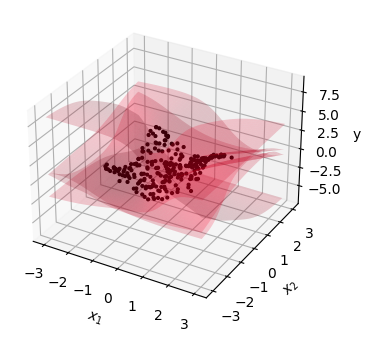

In [4]:
figure = visualization.RegressionFigure(
    settings=settings.SettingsRegressionFigure(
        settings_plot=settings.SettingsPlot(
            alpha=0.2,
            aleatoric=False
        )
    )
)
figure.plot(
    dataset=dataset,
    transformation=model_transformation.apply_from_vector,
    parameters_list=[samples_converted[:4]],
    std=sigmas.mean()
)

In [27]:
model = models.Regression(
    transformation=model_transformation,
    dataset=dataset
)

if method == "de":
    log_prob_means = computed_lppd_de(
        inputs=dataset.data_test[:, dataset.conditional_indices],
        outputs=dataset.data_test[:, dataset.dependent_indices],
        parameters_network=samples_converted,
        parameters_data_std=sigmas,
        regression_model=model
    )
    log_probs_sum = jnp.sum(log_prob_means, axis=0)
    log_probs_mean = jnp.mean(log_prob_means, axis=0)
    log_probs_std = jnp.std(log_prob_means, axis=0)
    print(f"dataset {dataset_name}, lppd for model: sum {log_probs_sum}, mean {log_probs_mean}, std {log_probs_std}")
    de_str = "{:.2f}, {:.2f}, {:.2f}".format(log_probs_sum.item(), log_probs_mean.item(), log_probs_std.item())
    print(de_str)
elif method == "la":
    log_prob_means = computed_lppd_la( # USE MCMC formulation here as well
        inputs=dataset.data_test[:, dataset.conditional_indices],
        outputs=dataset.data_test[:, dataset.dependent_indices],
        parameters_network=samples,
        parameters_data_std=sigmas,
        regression_model=model
    )
    log_probs_sum = jnp.sum(log_prob_means, axis=0)
    log_probs_mean = jnp.mean(log_prob_means, axis=0)
    log_probs_std = jnp.std(log_prob_means, axis=0)
    print(f"dataset {dataset_name}, lppd for model: sum {log_probs_sum}, mean {log_probs_mean}, std {log_probs_std}")
    la_str = "{:.2f}, {:.2f}, {:.2f}".format(log_probs_sum.item(), log_probs_mean.item(), log_probs_std.item())
    print(la_str)

dataset concrete, lppd for model: sum [-747.30347], mean [-3.6276867], std [4.6641603]
-747.30, -3.63, 4.66


# laplace approximation

In [35]:
import torch
import laplace
from torch.utils.data import Dataset, DataLoader
import numpy as np
from utils.conversion import flax_parameters_dict_to_torch_parameters_vector, torch_parameters_vector_to_flax_parameters_dict, torch_parameters_vector_to_flax_parameters_vector, torch_to_flax_permutation
from numpyro import distributions

In [36]:
point_estimate_la_vector = samples[0]

In [37]:
class ConditionalDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self._data = data
    
    def __getitem__(self, index):
        sample = self._data[index]
        conditional = sample[..., :-1]
        dependent = sample[..., -1:]
        return conditional, dependent
    
    def __len__(self):
        return len(self._data)

torch_dataset = ConditionalDataset(data=torch.from_numpy(np.array(dataset.data)))
train_loader = DataLoader(torch_dataset, batch_size=len(torch_dataset))

In [38]:
posterior_mean = samples_converted[0]
posterior_mean_la = samples[0]
print(posterior_mean.shape, posterior_mean_la.shape)

torch.nn.utils.vector_to_parameters(torch.tensor(posterior_mean_la, dtype=torch.float), model_transformation_la.parameters())

# initial la fit
hessian="diag"
model = model_transformation_la
la = laplace.Laplace(
    model=model,
    sigma_noise=sigmas.mean(),
    likelihood="regression",
    subset_of_weights="all",
    hessian_structure=hessian,
    prior_precision=1.0
)
la.fit(train_loader)

# optimize sigma noise and prior precision
log_prior, log_sigma = torch.zeros(1, requires_grad=True), torch.zeros(1, requires_grad=True)
print(log_prior.exp(), log_sigma.exp())
hyper_optimizer = torch.optim.Adam([log_sigma], lr=1e-2)
for i in range(int(1e3)):
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()
    if i % 100 == 0:
        with torch.no_grad():
            print(log_prior.exp(), log_sigma.exp())
print(log_prior.exp(), log_sigma.exp())

permutation_indices = torch_to_flax_permutation(template)

if hessian == "diag":
    posterior_precision = jnp.array(np.diag(la.posterior_precision.detach().numpy()))[permutation_indices][:, permutation_indices]
else:
    posterior_precision = jnp.array(la.posterior_precision.detach().numpy())[permutation_indices][:, permutation_indices]

posterior = distributions.MultivariateNormal(posterior_mean, precision_matrix=posterior_precision)
#la_samples_custom_0 = posterior.sample(rng_key, (1274, ))
la_samples_package = jnp.array(la.sample(n_samples=1274).detach().numpy())
la_samples_package_flax = la_samples_package[:, permutation_indices]

(13,) (13,)
tensor([1.], grad_fn=<ExpBackward0>) tensor([1.], grad_fn=<ExpBackward0>)
tensor([1.]) tensor([0.9900])
tensor([1.]) tensor([0.3735])
tensor([1.]) tensor([0.1860])
tensor([1.]) tensor([0.1639])
tensor([1.]) tensor([0.1638])
tensor([1.]) tensor([0.1638])
tensor([1.]) tensor([0.1638])
tensor([1.]) tensor([0.1638])
tensor([1.]) tensor([0.1638])
tensor([1.]) tensor([0.1638])
tensor([1.], grad_fn=<ExpBackward0>) tensor([0.1638], grad_fn=<ExpBackward0>)


In [39]:
la_samples = la_samples_package_flax
la_sigma = jnp.array(log_sigma.exp().detach().numpy())

In [40]:
print(la_samples)

[[-5.7899691e-02 -1.1150219e+00 -2.4440864e-03 ...  2.5916693e+00
   2.2502112e+00 -2.5007083e+00]
 [-5.8718741e-02 -1.1136029e+00  8.1680380e-03 ...  2.6034746e+00
   2.2181437e+00 -2.4946859e+00]
 [-5.7828918e-02 -1.0952556e+00  1.2046244e-04 ...  2.5995395e+00
   2.2329335e+00 -2.4901488e+00]
 ...
 [-5.9828378e-02 -1.1132224e+00 -5.3932648e-03 ...  2.5980175e+00
   2.2462349e+00 -2.4966729e+00]
 [-5.9709676e-02 -1.1037378e+00  1.6118337e-03 ...  2.5939209e+00
   2.2121522e+00 -2.4931741e+00]
 [-5.9935339e-02 -1.1081086e+00  2.9564474e-03 ...  2.6197691e+00
   2.2363274e+00 -2.4968956e+00]]


100%|████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 18.47it/s]


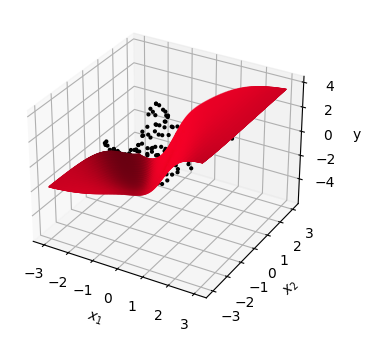

In [5]:
figure = visualization.RegressionFigure(
    settings=settings.SettingsRegressionFigure(
        settings_plot=settings.SettingsPlot(
            alpha=0.8,
            aleatoric=False
        )
    ),
)
figure_regression = figure.plot(
    dataset=dataset,
    transformation=model_transformation.apply_from_vector,
    parameters_list=[la_samples.squeeze()[:16]],
    std=0.1
)
figure_regression

In [42]:
model = models.Regression(
    transformation=model_transformation,
    dataset=dataset
)


log_prob_means = computed_lppd_la( # USE MCMC formulation here as well
    inputs=dataset.data_test[:, dataset.conditional_indices],
    outputs=dataset.data_test[:, dataset.dependent_indices],
    parameters_network=la_samples,
    parameters_data_std=jnp.ones((len(la_samples), 1)) * la_sigma,
    regression_model=model
)
log_probs_sum = jnp.sum(log_prob_means, axis=0)
log_probs_mean = jnp.mean(log_prob_means, axis=0)
log_probs_std = jnp.std(log_prob_means, axis=0)
print(f"dataset {dataset_name}, lppd for model: sum {log_probs_sum}, mean {log_probs_mean}, std {log_probs_std}")
la_str = "{:.2f}, {:.2f}, {:.2f}".format(log_probs_sum.item(), log_probs_mean.item(), log_probs_std.item())

print("de")
print(de_str)
print("la")
print(la_str)

dataset regression2d, lppd for model: sum [-inf], mean [-inf], std [nan]
de
-75.84, -1.46, 0.47
la
-inf, -inf, nan
